# Appendix: Other Analyses

This file holds several other data analyses, tests, and regressions that did not make it to our final paper. Particularly, our Common Redpoll snow level analysis and attempts at Zero-filled Poisson, Logistic, and Linear regressions revolving around Blue Jay observations in New York State.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

In [2]:
# importing sql
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

### Exploring snow levels and observation counts for the Common Redpoll  
As a secondary research question, we investigated how the Common Redpoll (_Acanthis flammea_) may tend to appear in differently sized groups at feeders when different levels of snow are present. Redpolls are a small, common feeder bird that is known to often appear in groups numbering in the hundreds.

`redpoll_df.csv` was created by taking a slice of the zero-filled New York dataset (`zero_filled_join.csv`) for only entries of scientific name _Acanthis flammea_.

In [3]:
redpoll_df = pd.read_csv("redpoll_df.csv")
print("Mean of redpoll count when snow is 0.0: " + str(redpoll_df[redpoll_df['0.0'] == 1]['how_many'].mean()))
print("Mean of redpoll count when snow is 0.001 - 5.0: " + str(redpoll_df[redpoll_df['0.001'] == 1]['how_many'].mean()))
print("Mean of redpoll count when snow is 5.0 - 15.001: " + str(redpoll_df[redpoll_df['5.0'] == 1]['how_many'].mean()))
print("Mean of redpoll count when snow is 15.001+: " + str(redpoll_df[redpoll_df['15.001'] == 1]['how_many'].mean()))

Mean of redpoll count when snow is 0.0: 10.871540826785104
Mean of redpoll count when snow is 0.001 - 5.0: 13.43467583497053
Mean of redpoll count when snow is 5.0 - 15.001: 14.675405405405405
Mean of redpoll count when snow is 15.001+: 19.30106237148732


At first glance, it appears that the count of redpolls at feeders per observation increases with increasing snow depth. This can be verified with Welch's two-sample t-test to evaluate if the mean counts are statistically significantly different for observations at feeders with no snow compared to observations at feeders with over 15 cm of snow.

Text(0.5, 1.0, 'Counts per observation with 15 cm+ of snow')

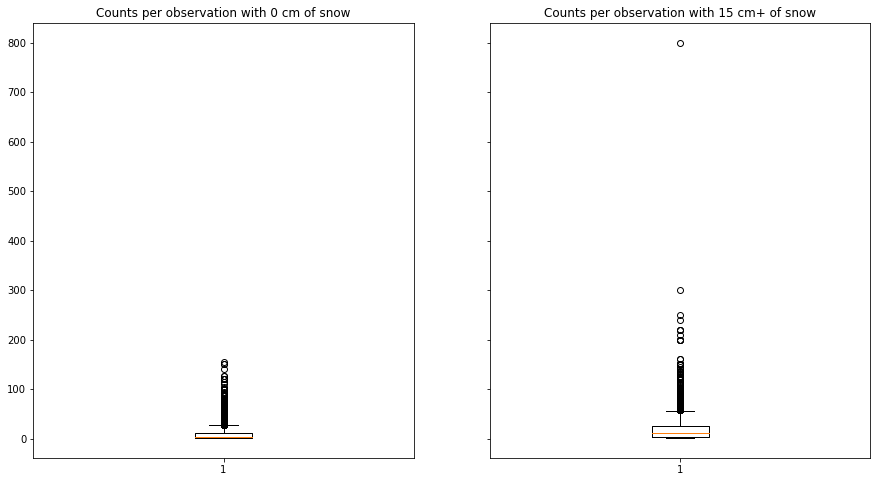

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)
ax1.boxplot(redpoll_df[redpoll_df['0.0'] == 1]['how_many'])
ax2.boxplot(redpoll_df[redpoll_df['15.001'] == 1]['how_many'])
ax1.set_title("Counts per observation with 0 cm of snow")
ax2.set_title("Counts per observation with 15 cm+ of snow")

In [7]:
stats.ttest_ind(redpoll_df[redpoll_df['0.0'] == 1]['how_many'], redpoll_df[redpoll_df['15.001'] == 1]['how_many'], equal_var = False)

Ttest_indResult(statistic=-17.973353614941498, pvalue=7.843153202349893e-71)

In [16]:
#removing outlier > 700 from heavy snow slice
redpoll_heavysnow = redpoll_df[redpoll_df['15.001']==1]
redpoll_heavysnow_no_outliers = redpoll_heavysnow[redpoll_heavysnow['how_many']<700]

In [15]:
stats.ttest_ind(redpoll_df[redpoll_df['0.0'] == 1]['how_many'], redpoll_heavysnow_no_outliers['how_many'], equal_var = False)

Ttest_indResult(statistic=-18.45348258160404, pvalue=2.1295227908330484e-74)

Notably, the t-test produces a surprisingly low p-value, indicating that the true mean of observed redpoll flock size at feeders when there is no snow on the ground is almost certainly not equal to the true mean of flock size when there is significant snow on the ground. This result could speak to behavioral changes throughout winter conditions that drive the formation of larger groups of individuals congregating around and relying heavily on specific feeders. 

Even removing the extremely large outlier from the 15cm+ subset of data results results in a small p-value too. 

The Common Redpoll are known to be in the Northeastern United States primarily in the winter, which may also be a confounding reason why the mean amount of redpolls is so high for heavy amounts of snow. Alternatively, this could be dependent on the bird's diet of seeds, which can more easily be found at bird feeders than scavanging the snow-covered ground.

Due to these possible confounding factors and its divergence from the final paper's focus on housing density, this test and exploration was removed from the final paper. 

### Zero-Inflated Poisson Regression: Predict number of birds in observation period given housing density and snow depth level

As suggested by the professor, we chose to attempt a Zero-Inflated Poisson Regression, given our zero-filled data is highly zero-inflated and this could negatively affect our regression if we want to predict `how_many` counts (how many birds seen during the observation period). We consulted [this source](https://timeseriesreasoning.com/contents/zero-inflated-poisson-regression-model/) to better understand how this regression works and based our code based on this example. 

In [42]:
#read in bluejay slice of zero-filled data
csv = pd.read_csv("bluejay_df.csv")
species_limited_df = pd.DataFrame(csv)
species_limited_df.drop(['Unnamed: 0'],  axis= 1, inplace= True)
# dropping rows where snow depth was null
species_limited_df = species_limited_df.dropna(subset=['snow_dep_atleast'])
# creating new category with string corresponding to each value in snow depth (for binning in the line plots)
species_limited_df['snow_category'] = 'No_Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 0.001, 'snow_category'] = 'Light_Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 5.000, 'snow_category'] = '5 to 15 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 15.001, 'snow_category'] = 'Heavy_Snow'
snow_dummies = pd.get_dummies(species_limited_df['snow_category'], drop_first=True)
species_limited_df = pd.concat([species_limited_df, snow_dummies], axis=1)
species_limited_df.drop(['snow_category', 'snow_dep_atleast'],  axis= 1, inplace= True)
species_limited_df.head()
# reading in raw provided data
csv_sites = pd.read_csv("PFW_count_site_data_public_2021.csv")
#creating dataframe
sites_df = pd.DataFrame(csv_sites)
# keeping only the columns that will be involved in analysis
sites_df = sites_df[['loc_id', 'proj_period_id', 'yard_type_pavement', 'yard_type_garden', 'yard_type_landsca', 'yard_type_woods', 
'yard_type_desert','hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 
'hab_water_salt', 'hab_residential','hab_industrial', 'hab_agricultural', 'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 
'hab_marsh', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'cats', 'dogs', 'humans',
'housing_density', 'population_atleast']]
%sql bluejay_join_df << SELECT month, day, year, species_limited_df.loc_id, species_code, how_many, day1_am, day1_pm, day2_am, day2_pm, Light_Snow, Heavy_Snow, No_Snow, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

Returning data to local variable bluejay_join_df


In [43]:
# dropping rows where housing density is null
bluejay_join_df = bluejay_join_df.dropna(subset=['housing_density'])
# creating new category with string 
bluejay_join_df['housing_density_bins'] = 'rural'
bluejay_join_df.loc[bluejay_join_df['housing_density'] == 2.0, 'housing_density_bins'] = "rural_suburban"
bluejay_join_df.loc[bluejay_join_df['housing_density'] == 3.0, 'housing_density_bins'] = "suburban"
bluejay_join_df.loc[bluejay_join_df['housing_density'] == 4.0, 'housing_density_bins'] = "urban"
density_dummies = pd.get_dummies(bluejay_join_df['housing_density_bins'], drop_first=True)
bluejay_join_df = pd.concat([bluejay_join_df, density_dummies], axis=1)

After formatting our data so that is usable and with dummy variables, below we run `ZeroInflatedPoisson` to predict `how_many` given the `housing_density` dummy variables and `snow_depth` dummy variables. 

We chose to split the data into a train and test set by slicing the dataset at the 0.8 mark, since the data is not necessarily organized by date but rather locationID. LocationIDs with similar values (alphabetically similar) do not necessarily have specific similarities, but are rather distinct.  

In [44]:
import statsmodels.api as sm
from patsy import dmatrices

mask = np.random.rand(len(bluejay_join_df)) < 0.8
bluejay_join_df_train = bluejay_join_df[mask]
bluejay_join_df_test = bluejay_join_df[~mask]

expr = 'how_many ~ rural_suburban + suburban + urban + Light_Snow + Heavy_Snow + No_Snow'
y_train, X_train = dmatrices(expr, bluejay_join_df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, bluejay_join_df_test, return_type='dataframe')

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()
print(zip_training_results.summary())

C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.352211
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                how_many   No. Observations:               930263
Model:             ZeroInflatedPoisson   Df Residuals:                   930256
Method:                            MLE   Df Model:                            6
Date:                 Mon, 21 Nov 2022   Pseudo R-squ.:                 0.02811
Time:                         15:51:00   Log-Likelihood:            -3.2765e+05
converged:                       False   LL-Null:                   -3.3713e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
inflate_Intercept          2.4406      0.012    209.892      0.000       2.418       2.463
inflate_rural_suburban     0.0980      0.011      8.893      0.000       0.076       0.

In [45]:
zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['how_many']
print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))

ZIP RMSE=547.9014509927857


In [46]:
predicted_counts.sum()

0.0

From summing the predicted counts, it is clear that the model is predicting 0 for all values because of the primarily 0 values in the test set. This is not a good model as it does not help us answer any questions about bird observation frequency based on housing density or snow depth levels. 

### Logistic Regression: Predict presence of Blue Jays given housing density

We also attempted to try a Logistic Regression using this zero-inflated data, understanding that it may have a similar issue to the Zero-Inflated Poisson attempt beforehand. 

In [50]:
# add new column that interprets `how_many` as a binary variable for logistic regression
bluejay_join_df['how_many_binary'] = np.where(bluejay_join_df['how_many']>0, 1, 0)

In [52]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

X = bluejay_join_df[['rural_suburban' , 'suburban' , 'urban']]
X_train, X_test, y_train, y_test = train_test_split(X, bluejay_join_df["how_many_binary"], test_size=0.2, random_state=2950)

model = LogisticRegression().fit(X_train,y_train)
y_hat_train=model.predict(X_train)
y_hat_test=model.predict(X_test)

print("variables", 'rural_suburban' , 'suburban' , 'urban')
print('intercept:', model.intercept_)
print('slope:', model.coef_)
train_accuracy = metrics.accuracy_score(y_train, y_hat_train)
print('train accuracy:', train_accuracy)
test_accuracy = metrics.accuracy_score(y_test, y_hat_test)
print('test accuracy:', test_accuracy)
train_precision = metrics.precision_score(y_train, y_hat_train)
print("train precision:", train_precision)
test_precision = metrics.precision_score(y_test, y_hat_test)
print("test precision:", test_precision)
train_recall = metrics.recall_score(y_train, y_hat_train)
print("train recall:", train_recall)
test_recall = metrics.recall_score(y_test, y_hat_test)
print("test recall:", test_recall)
train_F1 = metrics.f1_score(y_train, y_hat_train)
print("train F1:", train_F1)
test_F1 = metrics.f1_score(y_test, y_hat_test)
print("test F1:", test_F1)

variables rural_suburban suburban urban
intercept: [-2.70077955]
slope: [[-0.14062398 -0.18930203 -0.04633117]]
train accuracy: 0.9425618844207871
test accuracy: 0.9421276888481862


C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mkolb\anaconda3\envs\info2950\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train precision: 0.0
test precision: 0.0
train recall: 0.0
test recall: 0.0
train F1: 0.0
test F1: 0.0


Unforunately, as expected, the zero-filled data for Blue Jays resulted in a model that predicts the probability `how_many_binary`= 1 to be very low for all inputs. In fact, although our accuracy is high at 94%, the precision, recall, and F1 score are all 0. This is indicative that our model is only predicting 0 for all values and therefore predicting all non-zero entries incorrect, which are a small subset of the test (and training) data. 

The intercept of -2.7 can be interpreted such that when all binary covariates = 0, which means the the observation is from a rural area, the probability of observing > 0 birds is $e^{-2.7}$ / (1 + $e^{-2.7}$) = 0.06297. Changing to a more populous housing density such as suburban/rural, suburban, and urban  we expect the odds of observing > 0 birds to be multiplied by $e^{\beta}$, so by 0.8688, 0.8275, and 0.9547 respectively. 

From these results, it appears being in a rural area makes it more likely that you will have positive observations, urban being the second most likely, then suburban/rural and finally suburban. Although our model cannot provide accurate predicting for a new input X, it does provide us with some information about the effect of these covariates. 